# **NOTE: that running this notebook will take TENS of minutes due to the OMDB API calls!**

## Load Dependencies

In [1]:
import pandas as pd
import requests
from requests.exceptions import ReadTimeout
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Load IMDB data from SQL output

In [2]:
# Specify the path to your CSV file
csv_file_path = './Resources/movies_raw_imdb.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Keep required columns only
df = df[['tconst', 'averageRating', 'numVotes', 'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'Movie']]
df.head()

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie
0,tt0013274,6.8,59,0,2021,94,Documentary,Istoriya grazhdanskoy voyny
1,tt0015414,5.2,16,0,2000,60,0,La tierra de los toros
2,tt0015724,6.1,27,0,1993,102,"Drama,Mystery,Romance",Dama de noche
3,tt0035423,6.4,87965,0,2001,118,"Comedy,Fantasy,Romance",Kate & Leopold
4,tt0036606,6.5,345,0,1983,118,"Drama,War","Another Time, Another Place"


# Pull the OMDBAPI Data

**NOTE THIS QUERY TAKES HOURS TO COMPLETE**

In [ ]:
# Define the OMDB API Call
api_key = 'ac6cb27f'
omdb_url = 'http://www.omdbapi.com/'

def get_movie_details(imdb_id):
    params = {'apikey': api_key, 'i': imdb_id}
    
    # Set a maximum number of retries
    max_retries = 3
    
    for _ in range(max_retries):
        try:
            response = requests.get(omdb_url, params=params, timeout=(5, 10))  # Set timeout values as needed
            response.raise_for_status()  # Raise an exception for HTTP errors (4xx and 5xx)
            data = response.json()
            return data
        except ReadTimeout:
            print(f"Read timeout occurred for movie with IMDb ID {imdb_id}. Retrying...")
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            break  # Break out of the loop for other types of exceptions
    
    # Handle the case where the request was unsuccessful after retries
    print(f"Unable to fetch data for movie with IMDb ID {imdb_id}")
    return None

# Define the fields to extract
fields_to_extract = ['Title', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 
                     'Writer', 'Actors', 'Language', 'Country', 'Type', 'Metascore', 
                     'imdbRating', 'imdbVotes', 'BoxOffice', 'Production']

# Add new columns to dataframe
for field in fields_to_extract:
    df[f'OMDB_{field}'] = np.nan

In [3]:
# Grab start time
start_time = time.time()

# Iterate through each row in the DataFrame and append selected fields from the API response
for index, row in df.iterrows():
    # Print an update on progress as it processes
    if index%10000 == 0:
        print(f'working on index: {index}')
    
    # Check if the relevant fields are already populated
    if all(pd.notna(row[f'OMDB_{field}']) for field in fields_to_extract):
        continue  # Skip making API call for rows where data is already present
    
    movie_title = row['tconst']
    movie_details = get_movie_details(movie_title)

    # Check if movie details were retrieved successfully
    if movie_details:
        # Append selected fields to the DataFrame
        for field in fields_to_extract:
            column_name = f'OMDB_{field}'
            df.at[index, column_name] = movie_details.get(field, '')
    else:
        # Handle the case where movie details were not retrieved
        # You can choose to skip the row, set default values, or handle it in another way
        pass

# Print time taken
print("--- %s minutes ---" % round(((time.time() - start_time)/60,2))

Read timeout occurred for movie with IMDb ID tt0282124. Retrying...
Read timeout occurred for movie with IMDb ID tt0282124. Retrying...
Read timeout occurred for movie with IMDb ID tt29001902. Retrying...
Error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Unable to fetch data for movie with IMDb ID tt7246926


In [4]:
df.to_csv("./Resources/IMDB_OMDB_movies_raw.csv")

# Format column data types from objects to numbers

In [ ]:
# # Import and read the data if you screwed up :)
# movies_df = pd.read_csv("./Resources/IMDB_OMDB_movies_raw.csv")
# movies_df = movies_df[['tconst', 'averageRating', 'numVotes', 'isAdult', 'startYear', 'runtimeMinutes', 
#                        'genres', 'Movie', 'OMDB_Title', 'OMDB_Rated', 'OMDB_Runtime', 'OMDB_Genre', 
#                        'OMDB_Director', 'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country', 
#                        'OMDB_Type', 'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes', 
#                        'OMDB_BoxOffice', 'OMDB_Production']]
# movies_df.head()

In [34]:
# Examine data type of each column
movies_df=df
movies_df.dtypes

tconst              object
averageRating      float64
numVotes             int64
isAdult              int64
startYear            int64
runtimeMinutes       int64
genres              object
Movie               object
OMDB_Title          object
OMDB_Rated          object
OMDB_Released       object
OMDB_Runtime        object
OMDB_Genre          object
OMDB_Director       object
OMDB_Writer         object
OMDB_Actors         object
OMDB_Language       object
OMDB_Country        object
OMDB_Type           object
OMDB_Metascore      object
OMDB_imdbRating     object
OMDB_imdbVotes      object
OMDB_BoxOffice      object
OMDB_Production     object
dtype: object

In [35]:
# delate all "N/A"
movies_df = movies_df.replace('N/A', '')

# Convert $ objects to floats
movies_df[['OMDB_BoxOffice']] = movies_df[['OMDB_BoxOffice']].replace('[\$,\s]', '', regex=True)
movies_df[['OMDB_BoxOffice']] = movies_df[['OMDB_BoxOffice']].apply(pd.to_numeric, errors='coerce')

# Convert number strings with comma to float
movies_df[['OMDB_imdbVotes']] = movies_df[['OMDB_imdbVotes']].replace('[,\s]', '', regex=True)
movies_df['OMDB_imdbVotes'] = pd.to_numeric(movies_df['OMDB_imdbVotes'], errors='coerce')

# Convert runtime to float after removing " min"
movies_df[['OMDB_Runtime']] = movies_df[['OMDB_Runtime']].replace('[min\s]', '', regex=True)
movies_df['OMDB_Runtime'] = pd.to_numeric(movies_df['OMDB_Runtime'], errors='coerce')

# Convert the number strings to numeric
movies_df[['OMDB_imdbRating', 'OMDB_Metascore']] = movies_df[['OMDB_imdbRating', 'OMDB_Metascore']].apply(pd.to_numeric, errors='coerce')

# Change date to datetime type (Note "ReleaseDate" has inconsistent formatting / typos)
movies_df["OMDB_Released"] = pd.to_datetime(movies_df["OMDB_Released"])

movies_df.dtypes

tconst                     object
averageRating             float64
numVotes                    int64
isAdult                     int64
startYear                   int64
runtimeMinutes              int64
genres                     object
Movie                      object
OMDB_Title                 object
OMDB_Rated                 object
OMDB_Released      datetime64[ns]
OMDB_Runtime              float64
OMDB_Genre                 object
OMDB_Director              object
OMDB_Writer                object
OMDB_Actors                object
OMDB_Language              object
OMDB_Country               object
OMDB_Type                  object
OMDB_Metascore            float64
OMDB_imdbRating           float64
OMDB_imdbVotes            float64
OMDB_BoxOffice            float64
OMDB_Production            object
dtype: object

In [36]:
movies_df.to_csv("./Resources/IMDB_OMDB_formatted.csv")

# Minor Processing

## Convert dates into year and month columns removing date columns

In [37]:
# Change date to datetime type (Note "ReleaseDate" has inconsistent formatting / typos)
movies_df["OMDB_Released"] = pd.to_datetime(movies_df["OMDB_Released"])
movies_df

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie,OMDB_Title,OMDB_Rated,...,OMDB_Writer,OMDB_Actors,OMDB_Language,OMDB_Country,OMDB_Type,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production
0,tt0013274,6.8,59,0,2021,94,Documentary,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,,...,,,None,Soviet Union,movie,NaN,NaN,58.0,NaN,
1,tt0015414,5.2,16,0,2000,60,0,La tierra de los toros,La tierra de los toros,,...,,"Antonio Cañero, Musidora",None,"Spain, France",movie,NaN,6.6,16.0,NaN,
2,tt0015724,6.1,27,0,1993,102,"Drama,Mystery,Romance",Dama de noche,Dama de noche,,...,"Eva López Sánchez, David Martin del Campo","Rafael Sánchez Navarro, Cecilia Toussaint, Mig...",Spanish,Mexico,movie,NaN,5.8,27.0,NaN,
3,tt0035423,6.4,87965,0,2001,118,"Comedy,Fantasy,Romance",Kate & Leopold,Kate & Leopold,PG-13,...,"Steven Rogers, James Mangold","Meg Ryan, Hugh Jackman, Liev Schreiber","English, French",United States,movie,44.0,6.4,87977.0,47121859.0,
4,tt0036606,6.5,345,0,1983,118,"Drama,War","Another Time, Another Place","Another Time, Another Place",R,...,"Jessie Kesson, John Francis Lane, Michael Radford","Phyllis Logan, Giovanni Mauriello, Gianluca Fa...","English, Italian",United Kingdom,movie,NaN,6.5,338.0,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221928,tt9916270,5.8,1448,0,2020,84,Thriller,Il talento del calabrone,Il talento del calabrone,,...,"Giacomo Cimini, Lorenzo Collalti","Sergio Castellitto, Lorenzo Richelmy, Anna Fog...",Italian,"Italy, Spain",movie,NaN,5.8,1448.0,NaN,
221929,tt9916362,6.4,5609,0,2020,92,"Drama,History",Coven,Coven,TV-MA,...,"Pablo Agüero, Katell Guillou","Amaia Aberasturi, Alex Brendemühl, Daniel Fanego","Spanish, Basque","Spain, France, Argentina",movie,NaN,6.4,5603.0,NaN,
221930,tt9916428,3.5,17,0,2019,0,"Adventure,History,War",The Secret of China,The Secret of China,,...,,"Kenan Heppe, Wang Peng Kai, Valery Gadreau","Chinese, English",China,movie,NaN,3.5,17.0,NaN,
221931,tt9916538,8.6,7,0,2019,123,Drama,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,,...,"Arief Ash Siddiq, Rino Sarjono, Salman Aristo","Lala Karmela, Cut Mini Theo, Sahil Shah",Indonesian,Indonesia,movie,NaN,NaN,6.0,NaN,


In [38]:
movies_df.dtypes

tconst                     object
averageRating             float64
numVotes                    int64
isAdult                     int64
startYear                   int64
runtimeMinutes              int64
genres                     object
Movie                      object
OMDB_Title                 object
OMDB_Rated                 object
OMDB_Released      datetime64[ns]
OMDB_Runtime              float64
OMDB_Genre                 object
OMDB_Director              object
OMDB_Writer                object
OMDB_Actors                object
OMDB_Language              object
OMDB_Country               object
OMDB_Type                  object
OMDB_Metascore            float64
OMDB_imdbRating           float64
OMDB_imdbVotes            float64
OMDB_BoxOffice            float64
OMDB_Production            object
dtype: object

In [39]:
movies_df["ReleaseYear"] = pd.DatetimeIndex(movies_df['OMDB_Released']).year
movies_df["ReleaseMonth"] = pd.DatetimeIndex(movies_df['OMDB_Released']).month
movies_df = movies_df.drop(['OMDB_Released'], axis=1)
movies_df.head()

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie,OMDB_Title,OMDB_Rated,...,OMDB_Language,OMDB_Country,OMDB_Type,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production,ReleaseYear,ReleaseMonth
0,tt0013274,6.8,59,0,2021,94,Documentary,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,,...,None,Soviet Union,movie,NaN,NaN,58.0,NaN,,2022.0,5.0
1,tt0015414,5.2,16,0,2000,60,0,La tierra de los toros,La tierra de los toros,,...,None,"Spain, France",movie,NaN,6.6,16.0,NaN,,NaN,NaN
2,tt0015724,6.1,27,0,1993,102,"Drama,Mystery,Romance",Dama de noche,Dama de noche,,...,Spanish,Mexico,movie,NaN,5.8,27.0,NaN,,1993.0,3.0
3,tt0035423,6.4,87965,0,2001,118,"Comedy,Fantasy,Romance",Kate & Leopold,Kate & Leopold,PG-13,...,"English, French",United States,movie,44.0,6.4,87977.0,47121859.0,,2001.0,12.0
4,tt0036606,6.5,345,0,1983,118,"Drama,War","Another Time, Another Place","Another Time, Another Place",R,...,"English, Italian",United Kingdom,movie,NaN,6.5,338.0,NaN,,1984.0,5.0


In [40]:
movies_df.columns

Index(['tconst', 'averageRating', 'numVotes', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'Movie', 'OMDB_Title', 'OMDB_Rated',
       'OMDB_Runtime', 'OMDB_Genre', 'OMDB_Director', 'OMDB_Writer',
       'OMDB_Actors', 'OMDB_Language', 'OMDB_Country', 'OMDB_Type',
       'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes', 'OMDB_BoxOffice',
       'OMDB_Production', 'ReleaseYear', 'ReleaseMonth'],
      dtype='object')

# Investigate Inputs / Features: should any be consolidated or truncated

In [41]:
# Check distribution of ratings
ratings_count = movies_df['OMDB_Rated'].value_counts()
ratings_count

             161222
Not Rated     23575
R             15267
PG-13          5581
PG             3896
              ...  
K-14              1
K                 1
R-18+             1
R(A)              1
M/PG              1
Name: OMDB_Rated, Length: 95, dtype: int64

In [42]:
# Define Consolidate Rated Lists:
# reference https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system and Google for odd ones
kids = ['PG', 'G', 'TV-PG', 'TV-G', 'GP', 'M/PG', 'M', 'TV-Y7', 'U', 'TV-Y', 'Atp', 'Btl', 'E', 'TV-Y7-FV', '7', 'o.Al.', '6', 'Open', 'K-3', 'KT', 'UA', 'L', 'I', 'M/6', '7+', 'A.G.', 'All', 'K-8']
teens = ['PG-13', 'TV-14', '16+', '13+', '12', '13', '16', 'T', 'E10+', '11', '15', '14', 'M/12', 'MA-13', 'M/16', '-16', 'K-12', 'TV-13', '12A', 'PG-12', '10', 'K-16', 'IIA', 'PG13', 'R15+', 'II', 'K-13', 'KNT', 'K-14']
adults = ['R', 'TV-MA', 'NC-17', 'X', '18+', 'AO', '18', 'S', 'III', 'A', 'IIB', 'M/18', 'K-18', 'R-18', 'MA-17', 'M18', 'C', 'R18+', 'VM18', '18A', 'BPjM Restricted', 'R-18+', 'R(A)']
Unknown = ['Not Rated', 'Approved', 'Unrated', 'Passed', 'NOT RATED', 'UNRATED', 'APPROVED', '(Banned)', 'PASSED', 'EM', 'AL', 'F', 'B', 'Livre', 'K']

for index, row in movies_df.iterrows():
    movie_rating = row['OMDB_Rated']
    if movie_rating in kids:
        movies_df.at[index,'OMDB_Rated'] = 'kids'
    elif movie_rating in teens:
        movies_df.at[index,'OMDB_Rated'] = 'teens'
    elif movie_rating in adults:
        movies_df.at[index,'OMDB_Rated'] = 'adults'
    else:
        movies_df.at[index,'OMDB_Rated'] = 'unknown'

# df["grade"] = df.apply(lambda x: 'A+' if ((x['score']>40)&(x['score']<50)) else x["grade"], axis=1)
# movies_df.OMDB_Rated = np.where((movies_df.OMDB_Rated in kids), 'kids', movies_df.OMDB_Rated)

movies_df['OMDB_Rated'].value_counts()

unknown    187954
adults      19128
teens        8055
kids         6796
Name: OMDB_Rated, dtype: int64

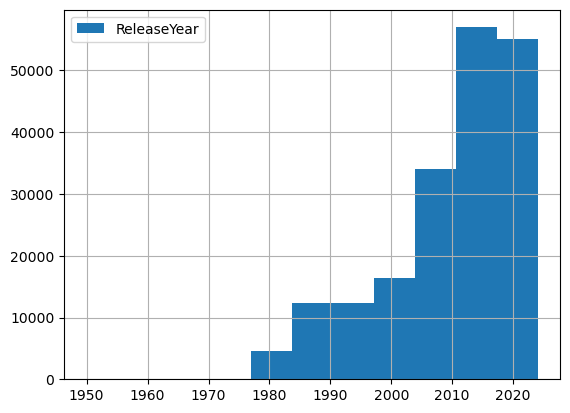

In [43]:
year_hist = movies_df['ReleaseYear'].hist(bins=11, legend=True)

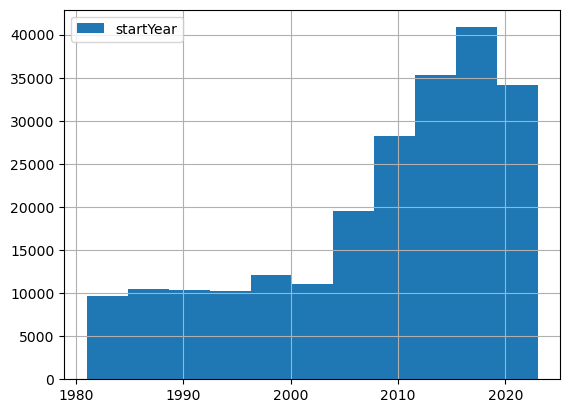

In [44]:
year_hist2 = movies_df['startYear'].hist(bins=11, legend=True)

In [50]:
movies_df['ReleaseYear'].value_counts()

2019.0    10033
2022.0     9804
2018.0     9596
2017.0     9461
2021.0     9086
2016.0     8872
2015.0     8804
2020.0     8602
2014.0     8330
2023.0     7922
2013.0     7803
2012.0     7094
2011.0     6631
2010.0     5837
2009.0     5731
2008.0     5470
2007.0     4888
2006.0     4515
2005.0     4024
2004.0     3606
2003.0     3333
2002.0     3082
2001.0     2876
2000.0     2545
1999.0     2366
1998.0     2143
1997.0     1982
1989.0     1854
1986.0     1813
1990.0     1807
1988.0     1799
1996.0     1799
1987.0     1767
1995.0     1758
1993.0     1726
1985.0     1706
1994.0     1704
1991.0     1702
1992.0     1673
1982.0     1616
1984.0     1610
1983.0     1562
1981.0     1459
2024.0       58
1980.0        2
1979.0        2
1978.0        1
1977.0        1
1959.0        1
1950.0        1
Name: ReleaseYear, dtype: int64

In [51]:
movies_df['startYear'].value_counts()

2019    10450
2018    10341
2017    10270
2022     9922
2016     9792
2015     9398
2014     9173
2021     8837
2013     8552
2020     8380
2012     8190
2011     7793
2010     7209
2023     7053
2009     6948
2008     6228
2007     5421
2006     5193
2005     4656
2004     4220
2003     3821
2002     3673
2001     3519
2000     3258
1999     3115
1998     2926
1997     2853
1989     2721
1988     2673
1987     2661
1996     2656
1990     2631
1986     2602
1995     2602
1991     2563
1985     2535
1984     2490
1993     2472
1994     2468
1992     2466
1983     2452
1982     2395
1981     2355
Name: startYear, dtype: int64

In [47]:
movies_df['genres'].value_counts()

Drama                         36688
Documentary                   29813
Comedy                        16384
Comedy,Drama                   7789
Horror                         6407
                              ...  
Musical,Sci-Fi,Thriller           1
Adventure,Horror,Western          1
Biography,Romance,War             1
Biography,Fantasy,Horror          1
Action,Documentary,Mystery        1
Name: genres, Length: 1155, dtype: int64

In [48]:
movies_df['OMDB_Genre'].value_counts()

Drama                                                         36534
Documentary                                                   29704
Comedy                                                        16374
Comedy, Drama                                                  7576
                                                               7268
                                                              ...  
Fantasy, Musical, Family                                          1
Comedy, Crime, Drama, Thriller                                    1
Animation, Adventure, Comedy, Drama                               1
Adventure, Fantasy, Family                                        1
Action, Adventure, Crime, Drama, Mystery, Sci-Fi, Thriller        1
Name: OMDB_Genre, Length: 1817, dtype: int64

In [49]:
genre_counts = movies_df['genres'].value_counts()
genre_counts.loc[lambda x : x > 1000]

Drama                    36688
Documentary              29813
Comedy                   16384
Comedy,Drama              7789
Horror                    6407
0                         6262
Drama,Romance             5772
Thriller                  4166
Comedy,Romance            3755
Comedy,Drama,Romance      3716
Action                    3618
Drama,Thriller            2707
Action,Crime,Drama        2342
Horror,Thriller           2254
Romance                   2253
Crime,Drama               1992
Action,Drama              1808
Documentary,Music         1768
Biography,Documentary     1657
Adult                     1620
Crime,Drama,Thriller      1529
Comedy,Horror             1379
Drama,Family              1267
Family                    1206
Action,Thriller           1054
Documentary,History       1023
Name: genres, dtype: int64

## Notes on feature distributions:
* OMDB_Rated had 20 categories with overlap which have been reduced to 4 categories: kids (G, PG), teens (PG13), adults(NC-17+, R), and unknown
* There are differences between Release Year and Start Year - if we use this feature, we need to better understand the meaning
* THe original IMDB genre category appears easier to clean if we choose to use that feature

# Investigate Output / Target Compares between two sources

In [45]:
movies_df.groupby(['OMDB_Rated'])['averageRating'].mean()

OMDB_Rated
adults     5.585529
kids       6.155268
teens      6.010764
unknown    6.284415
Name: averageRating, dtype: float64

In [46]:
movies_df.groupby(['OMDB_Rated'])['OMDB_imdbRating'].mean()

OMDB_Rated
adults     5.582631
kids       6.120541
teens      5.994701
unknown    6.160632
Name: OMDB_imdbRating, dtype: float64

In [57]:
movies_df.groupby(['OMDB_Rated'])['averageRating'].count()

OMDB_Rated
adults      19128
kids         6796
teens        8055
unknown    187954
Name: averageRating, dtype: int64

In [58]:
movies_df.groupby(['OMDB_Rated'])['OMDB_imdbRating'].count()

OMDB_Rated
adults      18855
kids         6543
teens        7851
unknown    154119
Name: OMDB_imdbRating, dtype: int64

The r-squared is: 0.4508799829420206


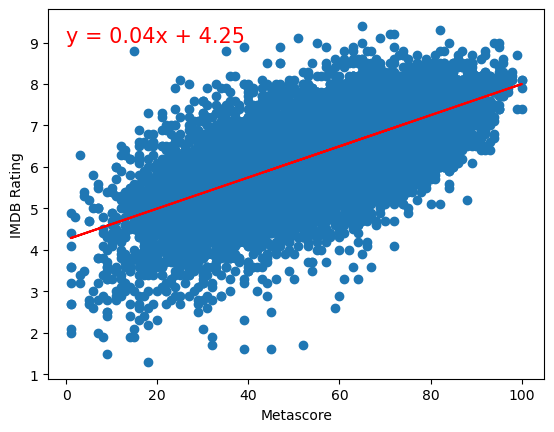

In [53]:
# Define the x and y
movies_df_no_nan = movies_df[['OMDB_Metascore', 'averageRating']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['OMDB_Metascore']
y_values = movies_df_no_nan['averageRating']

# Calculate the regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the different factors in a scatter plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,9),fontsize=15,color="red")
plt.xlabel('Metascore')
plt.ylabel('IMDB Rating')

print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.45047154294997077


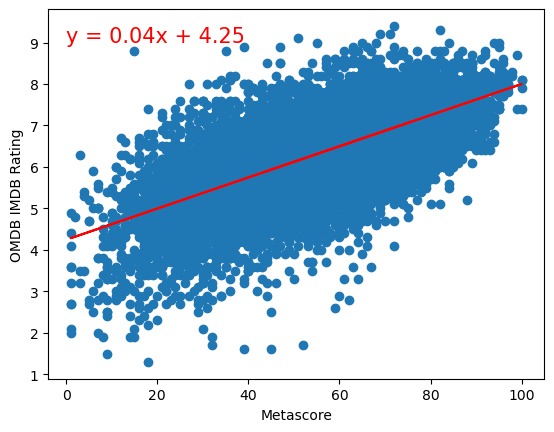

In [54]:
# Define the x and y
movies_df_no_nan = movies_df[['OMDB_Metascore', 'OMDB_imdbRating']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['OMDB_Metascore']
y_values = movies_df_no_nan['OMDB_imdbRating']

# Calculate the regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the different factors in a scatter plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,9),fontsize=15,color="red")
plt.xlabel('Metascore')
plt.ylabel('OMDB IMDB Rating')

print(f"The r-squared is: {rvalue**2}")
plt.show()

## Notes on outputs / targets:
* The OMDB entry for IMDB ratings does not align perfectly with ratings reported directly from IMDB. For the purposes of this project timeline, they are close enough to not dig into further

# Export final file

In [55]:
movies_df.to_csv("./Resources/IMDB_OMDB_processed.csv")